# Practical Session 4 - Deep Learning with PyTorch
In this session we will start with our toy task again.
Remember how we solved it with an MLP in the first class ?
We used scikit-learn, a one liner but without control over what was happening.

We will start by implementing the model in Pytorch, in a basic way.

Then we will work our way to making our code looks like a real Pytorch code.

In [134]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import time

np.random.seed(20)


def base_function():
    f = lambda x: 1.3 * x ** 3 - 3 * x ** 2 + 3.6 * x + 6.9
    return f

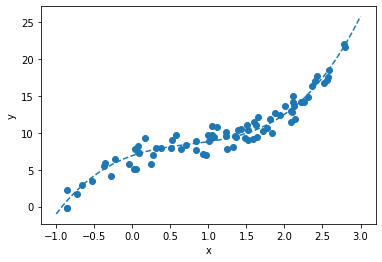

In [135]:

low, high = -1, 3
n_points = 80

# Get the values
bfunc = base_function()
xs = np.random.uniform(low, high, n_points)
ys_noise = np.random.normal(size=len(xs))
sample_ys = bfunc(xs)
noisy_sample_ys = sample_ys + ys_noise

# Plot the hidden function
lsp = np.linspace(low, high)
true_ys = bfunc(lsp)
plt.plot(lsp, true_ys, linestyle='dashed')

# Plot the samples
plt.scatter(xs, noisy_sample_ys)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

We used the following command to fit the regressor last time :
"from sklearn.neural_network import MLPRegressor
 mlp_model = MLPRegressor(max_iter=5000)"

By default, the MLP Regressor makes the following computational graph :
- input gets multiplied by 100 parameters, and an additional parameter is added to each values, giving 100 outputs y
- ReLU is applied to each of these outputs
- Then all outputs are multiplied by a parameter (again 100 parameters) and all these values are summed and added to the result

To make the two big multiplications, we will use one torch tensor of 100 parameters for each multiplication.

In [136]:
# First create the parameters with small random initial values.
# We need to mention that we want to compute a gradient
# I provide you with the example for the first one :
w1 = torch.normal(mean=0., std=0.1, size=(100, 1), requires_grad=True)
b1 = torch.normal(mean=0., std=0.1, size=(1,), requires_grad=True)
w2 = torch.normal(mean=0., std=0.1, size=(100, 1), requires_grad=True)
b2 = torch.normal(mean=0., std=0.1, size=(1,), requires_grad=True)

In [148]:
# Then define the function
def f(x, weight1=w1, bias1=b1, weight2=w2, bias2=b2):
    y1 = weight1 * x + bias1
    a1 = torch.nn.functional.relu(y1)
    out = torch.sum(a1 * weight2, dim=0) + bias2
    return out


# Just to be sure everything runs, we make an inference on one input
sample_input = torch.ones(size=(1,))
f(sample_input).shape

torch.Size([1])

Now we will mostly use last class optimization procedure to train our network using Pytorch



In [138]:
# Also set up the data
# Check that when doing inference on the data, we get an output tensor of size 80
# Call us if it is not the case, there is something ~ subtle and not interesting
torch_xs = torch.from_numpy(xs)[None, :]
torch_ys = torch.from_numpy(noisy_sample_ys)
f(torch_xs).shape

torch.Size([80])

In [139]:
# Now like last time, let us define an optimizer and give the parameters to it.
n_iter = 100
opt = torch.optim.Adam([w1, b1, w2, b2], lr=0.01)

In [140]:
for i in range(n_iter):
    prediction = f(torch_xs, w1, b1, w2, b2)
    loss = torch.mean((prediction - torch_ys) ** 2)
    loss.backward()
    opt.step()
    opt.zero_grad()
    if not i % 10:
        print(i, loss.item())

0 122.08734380851972
10 65.8785346515202
20 5.135073100245597
30 9.742052029919284
40 3.0890309969216245
50 3.4087847857512017
60 2.922226419139967
70 2.734008395290053
80 2.7423106193705546
90 2.6914925080116037


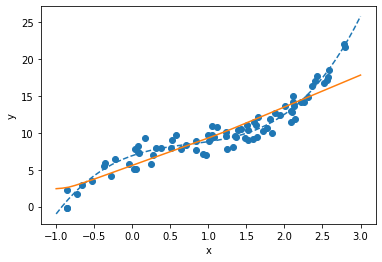

In [141]:
torch_lsp = torch.from_numpy(lsp)
predicted_ys = f(torch_lsp).detach().numpy()

plt.plot(lsp, true_ys, linestyle='dashed')
plt.plot(lsp, predicted_ys)

# Plot the samples
plt.scatter(xs, noisy_sample_ys)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

Congratulations, you have coded yourself a MLP model ! We have used the computation graph framework.
Now let us make our code prettier (more Pytorch) and more efficient !

First let us refactor the model in the proper way it should be coded, by using the torch.nn.Module class.
You should add almost no new code, just reorganize the one above into a class.

In [142]:
from torch.nn import Module, Parameter


class MyOwnMLP(Module):
    def __init__(self):
        super(MyOwnMLP, self).__init__()
        self.w1 = Parameter(torch.normal(mean=0., std=0.1, size=(100, 1)))
        self.b1 = Parameter(torch.normal(mean=0., std=0.1, size=(1,)))
        self.w2 = Parameter(torch.normal(mean=0., std=0.1, size=(100, 1)))
        self.b2 = Parameter(torch.normal(mean=0., std=0.1, size=(1,)))

    def forward(self, x):
        y1 = self.w1 * x + self.b1
        a1 = torch.nn.functional.relu(y1)
        out = torch.sum(a1 * self.w2, dim=0) + self.b2
        return out


model = MyOwnMLP()
out = model(torch_xs)
out.shape

torch.Size([80])

Now we are good to also make the data iteration process look like Pytorch code !

We need to define a Dataset object. Once we have this, we can use it to create a DataLoader object

In [143]:
from torch.utils.data import Dataset, DataLoader


class CustomDataset(Dataset):
    def __init__(self, data_x, data_y):
        self.data_x = data_x
        self.data_y = data_y

    def __len__(self):
        return len(self.data_x)

    def __getitem__(self, idx):
        x = self.data_x[idx]
        y = self.data_y[idx]
        return x, y

In [144]:
# Loop and wait for each data point in PyTorch
dataset = CustomDataset(data_x=xs, data_y=noisy_sample_ys)
dataloader = DataLoader(dataset=dataset, batch_size=10, num_workers=6)
start = time.time()
for point in dataloader:
    pass
print('Done in pytorch : ', time.time() - start)

Done in pytorch :  0.05472087860107422


The last thing missing to make our pipeline truly Pytorch is to use a GPU.

In Pytorch it is really easy, you just need to 'move' your tensors to a 'device'.
You can test if a gpu is available and create the appropriate device with the following lines:

In [145]:
device = 'gpu' if torch.cuda.is_available() else 'cpu'
torch_xs = torch_xs.to(device)

Now we finally have all the elements to make an actual Pytorch complete pipeline !

Create a model, and try to put it on a device.
Create an optimizer with your model's parameters
Make your data into a dataloader

Then use two nested for loops : one for 100 epochs, and in each epoch loop over the dataloader
    Inside the loop, for every batch first put the data on the device
    Then use the semantics of above :
        - model(batch)
        - loss computation and backward
        - gradient step and zero_grad

In [146]:
n_epochs = 200
model = MyOwnMLP()
opt = torch.optim.Adam(model.parameters(), lr=0.01)

dataset = CustomDataset(data_x=xs, data_y=noisy_sample_ys)
dataloader = DataLoader(dataset=dataset, batch_size=10, num_workers=6)

loss = 0
for epoch in range(n_epochs):
    for batch_x, batch_y in dataloader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        prediction = model(batch_x)
        loss = torch.mean((prediction - batch_y) ** 2)
        loss.backward()
        opt.step()
        opt.zero_grad()
        loss = loss.item()
    if not epoch % 10:
        print(epoch, loss)

# To easily use the trained model we need to send it back to cpu at the end
model = model.to('cpu')

0 120.45785424073111
10 5.174926444271767
20 4.95748963864474
30 4.719465816959692
40 4.5147076672615984
50 4.335283004134291
60 4.171850699672719
70 4.023569839563421
80 3.8816770788569337
90 3.7214379715969423
100 3.561050035586013
110 3.4047122089062336
120 3.2551898711484837
130 3.10609623429049
140 2.933859730176305
150 2.84113756942939
160 2.7053836912904514
170 2.5900340213973174
180 2.4944743890273653
190 2.4331432377920033


We finally can plot the last model

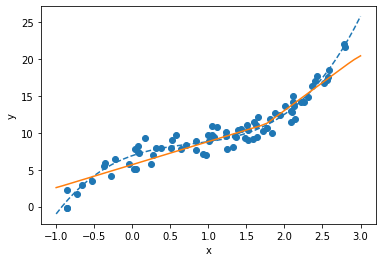

In [147]:
torch_lsp = torch.from_numpy(lsp)
predicted_ys = model(torch_lsp).detach().numpy()

plt.plot(lsp, true_ys, linestyle='dashed')
plt.plot(lsp, predicted_ys)

# Plot the samples
plt.scatter(xs, noisy_sample_ys)
plt.xlabel('x')
plt.ylabel('y')
plt.show()